## 1. Load Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

## 2. Load Data

I am using Baseball Savant data from their custom hitter leaderboard tool. All data was accumulated between Opening Day and the morning of June 26, 2025. This data is compiled by Baseball Savant and is publicly available online for free. This dataset contains 162 observations with 10 features. 

In [38]:
df = pd.read_csv("dba_25.csv")

## 3. Feature Selection

I have selected seven features that adequately contextualize a hitter's performance over the course of the season. There is a mix of features that favor the hitter and pitcher; for example, a higher K% is good for the pitcher, but a higher BB% is worse for the pitcher. In full, though, the stats come together to provide a well-rounded understanding of a pitcher's performance.

In [39]:
hitting_features = [
    'k_percent',         
    'bb_percent',       
    'on_base_plus_slg',   
    'exit_velocity_avg',  
    'barrel_batted_rate',  
    'hard_hit_percent',   
    'sprint_speed']

X_hitting = df[hitting_features].dropna()


## 4. Data Standardization

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hitting)


## 5. K-Distance

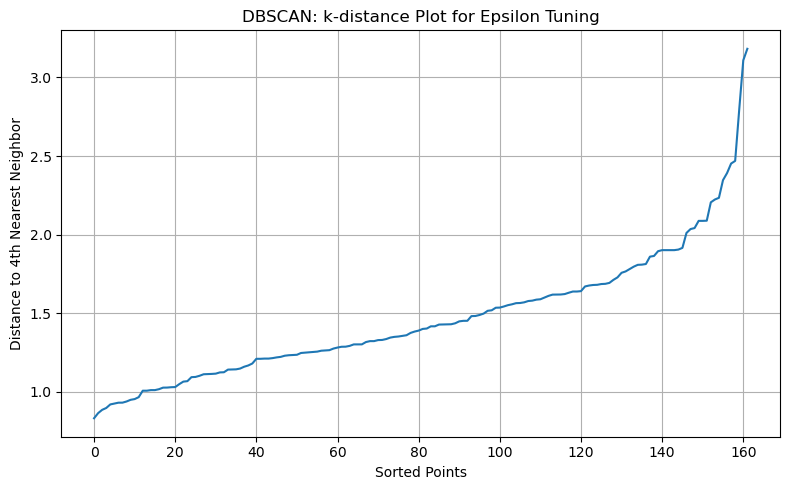

In [41]:
k = 4                                           
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)

distances, _ = neigh.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])          

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Sorted Points")
plt.ylabel(f"Distance to {k}th Nearest Neighbor")
plt.title("DBSCAN: k-distance Plot for Epsilon Tuning")
plt.grid(True)
plt.tight_layout()
plt.show()


The k-distance plot shows the distance to the 4th nearest neighbor for each hitter. The curve starts with a gradual, stead incline before rapidly turning upward around a distance of 1.9 (sorted points = 140). This is a clear threshold for the moment where points start to become isolated.

I will use this 1.9 value as the value for eps in the following DBSCAN implementation. 

## 6. DBSCAN Implementation

In [42]:
db = DBSCAN(eps=1.9, min_samples=5)            
labels = db.fit_predict(X_scaled)

X_hitting_result = X_hitting.copy()
X_hitting_result['Cluster'] = labels

## 7. Principal Component Analysis

In [43]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_hitting_result['PCA1'] = X_pca[:, 0]
X_hitting_result['PCA2'] = X_pca[:, 1]

## 8. Scatter Plot For PCA Clusters

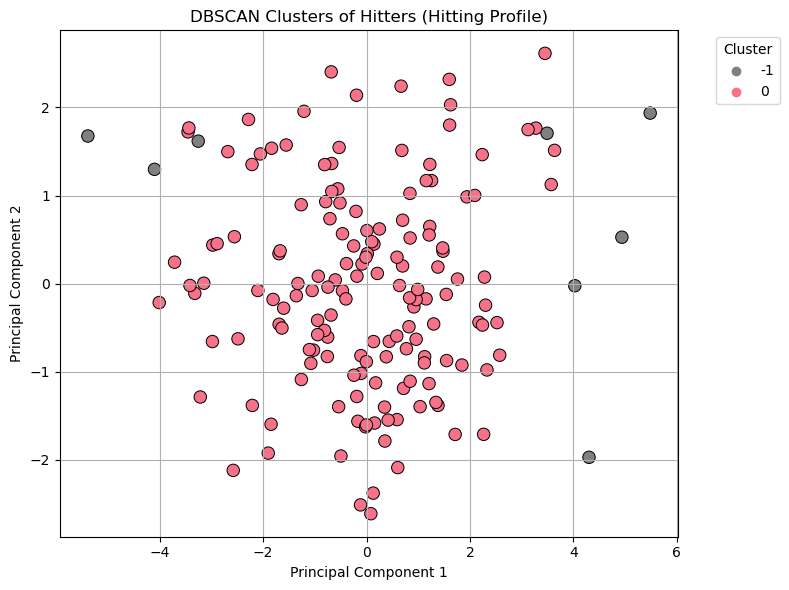

-1      8
 0    154
Name: Cluster, dtype: int64


In [44]:
unique_labels = sorted(set(labels))
palette = sns.color_palette('husl', len(unique_labels) - (1 if -1 in unique_labels else 0))
if -1 in unique_labels:
    palette = [(0.5, 0.5, 0.5)] + palette  
label_colours = {lbl: palette[i] for i, lbl in enumerate(unique_labels)}
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_hitting_result,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette=label_colours,
    s=80,
    edgecolor='k',
    legend='full'
)
plt.title("DBSCAN Clusters of Hitters (Hitting Profile)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
print(X_hitting_result['Cluster'].value_counts().sort_index())

This scatter plot shows the DBSCAN clustering results for hitters using the features I selected. Nearly all points are grouped into a single cluster, as shown by the pink plotted points (cluster = 0). The remaining points are the few outliers, all shown in gray (cluster = -1). The fact that there is only one main grouping (with a few outliers) indicates that most hitter performances are so similar to each other that it was impossible to identify distinct thresholds for clustering. 

## 9. Changing EPS

I was curious what would happen if I changed the eps value to something other than the ideal value of 1.9. I experimented with 1.0, 1.1, 1.2, 1.3, and 1.4. The implementation of eps=1.1 is shown below. The groupings here are seemingly worse than in my implementation of eps=1.9, which seems to confirm that the 1.9 value was indeed ideal, as indicated by the k-distance plot.

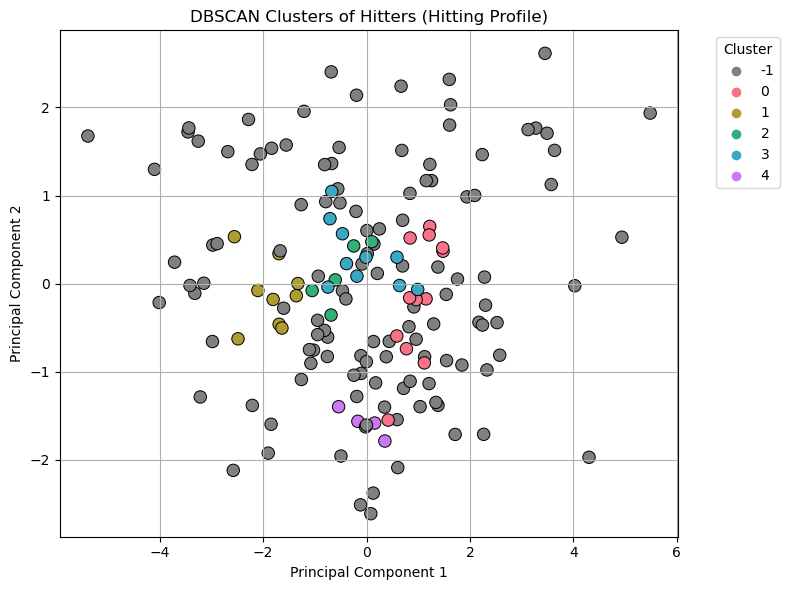

-1    122
 0     12
 1      9
 2      5
 3     10
 4      4
Name: Cluster, dtype: int64


In [45]:
db = DBSCAN(eps=1.1, min_samples=5)            
labels = db.fit_predict(X_scaled)
X_hitting_result = X_hitting.copy()
X_hitting_result['Cluster'] = labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_hitting_result['PCA1'] = X_pca[:, 0]
X_hitting_result['PCA2'] = X_pca[:, 1]
unique_labels = sorted(set(labels))
palette = sns.color_palette('husl', len(unique_labels) - (1 if -1 in unique_labels else 0))
if -1 in unique_labels:
    palette = [(0.5, 0.5, 0.5)] + palette  
label_colours = {lbl: palette[i] for i, lbl in enumerate(unique_labels)}
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_hitting_result,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette=label_colours,
    s=80,
    edgecolor='k',
    legend='full'
)
plt.title("DBSCAN Clusters of Hitters (Hitting Profile)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
print(X_hitting_result['Cluster'].value_counts().sort_index())